In [1]:
import anndata as ad
import numpy as np
from scvi.model import SCVI


TABULA_SAPIENS_BY_CELL_TYPE_WITH_EMBEDS_PT = "/Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_by_features_with_embeds_new_norm.h5ad"
TABULA_SAPIENS_BY_CELL_TYPE_SCVI_MODEL = "/Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_by_features_scvi_model_new_norm_sm/"

adata = ad.read_h5ad(TABULA_SAPIENS_BY_CELL_TYPE_WITH_EMBEDS_PT)

Global seed set to 0
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
model = SCVI.load(TABULA_SAPIENS_BY_CELL_TYPE_SCVI_MODEL, adata=adata)

INFO     File /Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_by_featu
         res_scvi_model_new_norm_sm/model.pt already downloaded                              


/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [3]:
model

SCVI Model with the following params: 
n_hidden: 256, n_latent: 32, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

In [4]:
# import torch
# import torch.nn as nn

# class Log1pSoftmax(nn.Module):
#     def __init__(self, dim=None):
#         super(Log1pSoftmax, self).__init__()
#         self.softmax = nn.Softmax(dim=dim)
        
#     def forward(self, input):
#         return torch.log1p(self.softmax(input))

# # model = SCVI(adata_train, n_layers=2, n_hidden=64, n_latent=16)
# # model = SCVI(adata_train)
# model.module.decoder.px_scale_decoder[1] = nn.Softplus()
# model.module.decoder.px_scale_decoder[1] = nn.Softmax(dim=-1)
# # model.module.decoder.px_scale_decoder[1] = Log1pSoftmax(dim=-1)

In [5]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

In [6]:
import scanpy as sc


adata.layers["prediction"] = model.get_normalized_expression(
    library_size=1e5
)
sc.pp.log1p(adata, layer='prediction')

In [7]:
# df = model.differential_expression(groupby='label')
# TABULA_SAPIENS_BY_CELL_TYPE_SCVI_DE = "/Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_by_features_scvi_model_new_norm_de.csv"
# df.to_csv(TABULA_SAPIENS_BY_CELL_TYPE_SCVI_DE)

In [8]:
from rosa.score import score_predictions
from rosa.plotting import plot_expression_and_correlation, plot_marker_gene_heatmap


adata_test, results = score_predictions(adata)


        mean pearsonr across genes 0.883
        mean pearsonr across cells 0.458
        mean square error 0.248
        ks-statistic on total expression 0.203
        mean percent total expression captured per cell 96.939
        


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc


def plot_marker_gene_heatmap(adata, marker_genes):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 12), gridspec_kw={"wspace": 0})
    sc.pl.matrixplot(
        adata,
        marker_genes,
        groupby="label",
        gene_symbols="feature_name",
        layer=None,
        vmin=0,
        vmax=6,
        ax=ax1,
        show=False,
        title="measured",
        dendrogram=True,
    )
    fig.axes[-1].remove()
    fig.axes[-1].remove()
    fig.axes[-1].remove()
    if type(marker_genes) is dict:
        fig.axes[-1].remove()

    sc.pl.matrixplot(
        adata,
        marker_genes,
        groupby="label",
        gene_symbols="feature_name",
        layer="prediction",
        vmin=0,
        vmax=6,
        ax=ax2,
        show=False,
        title="predicted",
        dendrogram=True,
    )
    fig.axes[-1].remove()
    fig.axes[-1].remove()
    fig.axes[-1].remove()
    if type(marker_genes) is dict:
        fig.axes[-1].remove()
    fig.axes[-1].set_yticklabels([])


def plot_expression_and_correlation(adata, results):
    _, axs = plt.subplots(3, 2, figsize=(14, 13), gridspec_kw={"wspace": 0.2})

    max_expression_val = 6
    # Subplot with expression histograms
    bins = np.linspace(0, max_expression_val, 1000)
    axs[0, 0].hist(adata.X.flatten(), bins=bins, density=True)
    axs[0, 0].hist(
        adata.layers["prediction"].flatten(), bins=bins, density=True, alpha=0.5
    )
    axs[0, 0].set_ylim([0, 10])
    axs[0, 0].set_xlim([0.001, max_expression_val])
    axs[0, 0].set_xlabel("expression")
    axs[0, 0].set_xscale("log")

    # Subplot with expression scatter
    axs[0, 1].plot(
        adata.X.flatten(), adata.layers["prediction"].flatten(), ".", alpha=0.01
    )
    axs[0, 1].plot(
        [0, max_expression_val],
        [0, max_expression_val],
        "k",
        linewidth="2",
        linestyle="--",
    )
    axs[0, 1].set_xlim([0, max_expression_val])
    axs[0, 1].set_ylim([0, max_expression_val])
    axs[0, 1].set_aspect("equal", adjustable="box")
    axs[0, 1].set_xlabel("expression actual")
    axs[0, 1].set_ylabel("expression predicted")

    # Subplot with correlation across genes
    axs[1, 0].hist(
        results["pearsonr_across_genes"], bins=np.linspace(0, 1, 50), density=True
    )
    axs[1, 0].set_xlabel("pearsonr across genes (each data point is a cell)")
    axs[1, 0].set_xlim([0, 1])

    # Subplot with correlation across genes
    axs[1, 1].hist(
        results["pearsonr_across_cells"], bins=np.linspace(0, 1, 100), density=True
    )
    axs[1, 1].set_xlabel("pearsonr across cells (each data point is a gene)")
    axs[1, 1].set_xlim([0, 1])

    # Subplot with correlation vs mean expression for genes
    axs[2, 1].plot(
        adata.X.mean(axis=0), results["pearsonr_across_cells"], ".", alpha=0.1
    )
    axs[2, 1].set_xlabel("mean expression across cells (each data point is a gene)")
    axs[2, 1].set_ylabel("pearsonr across cells")
    axs[2, 1].set_xlim([0, max_expression_val])

    axs[2, 0].set_visible(False)


In [15]:
!pip install scikit-plot

In [18]:
import scikitplot as skp

In [24]:
from scipy.stats import kstest

# Extract measured and predicted expression
X_meas = adata_test.X
X_pred = adata_test.layers["prediction"]

ks = kstest(X_pred.ravel(), X_meas.ravel())

In [25]:
ks

KstestResult(statistic=0.2027316441366791, pvalue=0.0)

In [27]:
from scipy import stats

In [36]:
bins
np.histogram()

7.6491804

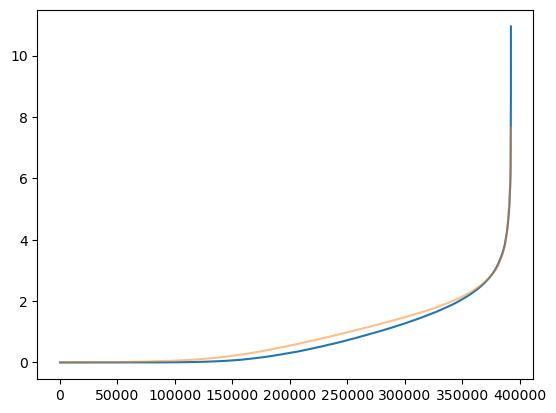

In [45]:
plt.plot(np.sort(X_meas.ravel()));
plt.plot(np.sort(X_pred.ravel()), alpha=0.5);


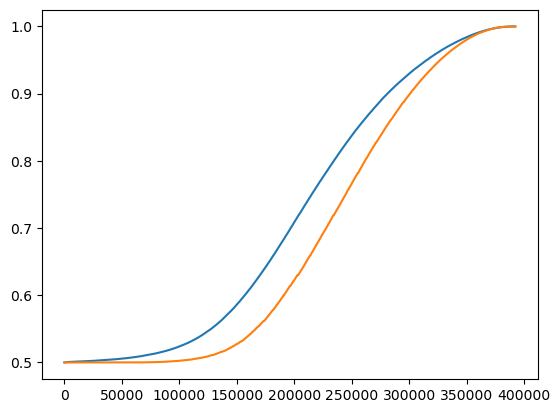

In [41]:
plt.plot(stats.norm.cdf(np.sort(X_pred.ravel())));
plt.plot(stats.norm.cdf(np.sort(X_meas.ravel())));

In [26]:
plt.plot(X_pred.ravel() - X_meas.ravel())

ValueError: Cannot calculate KS statistic for data with 390649 category/ies

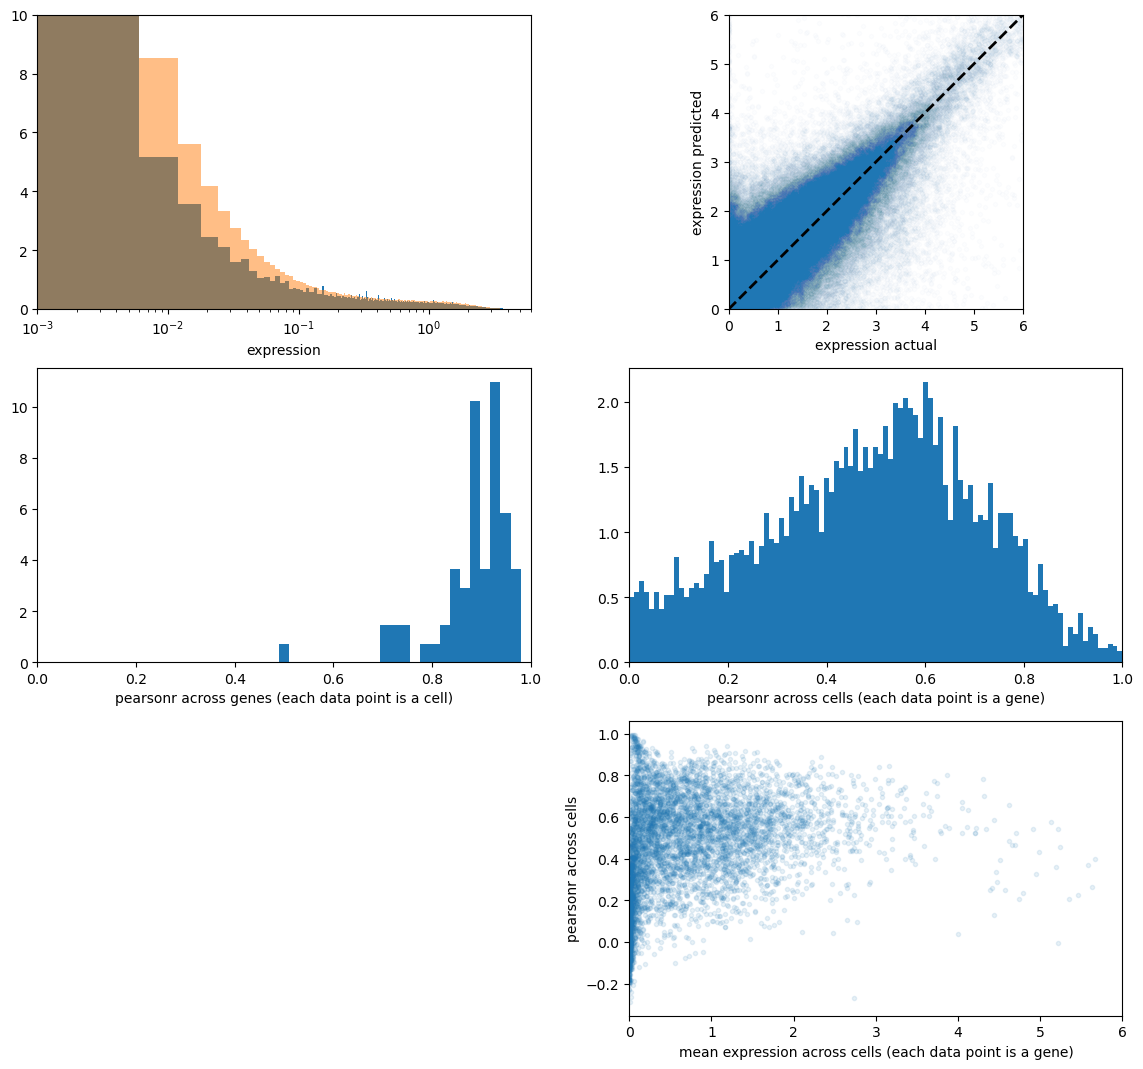

In [10]:
plot_expression_and_correlation(adata_test, results)

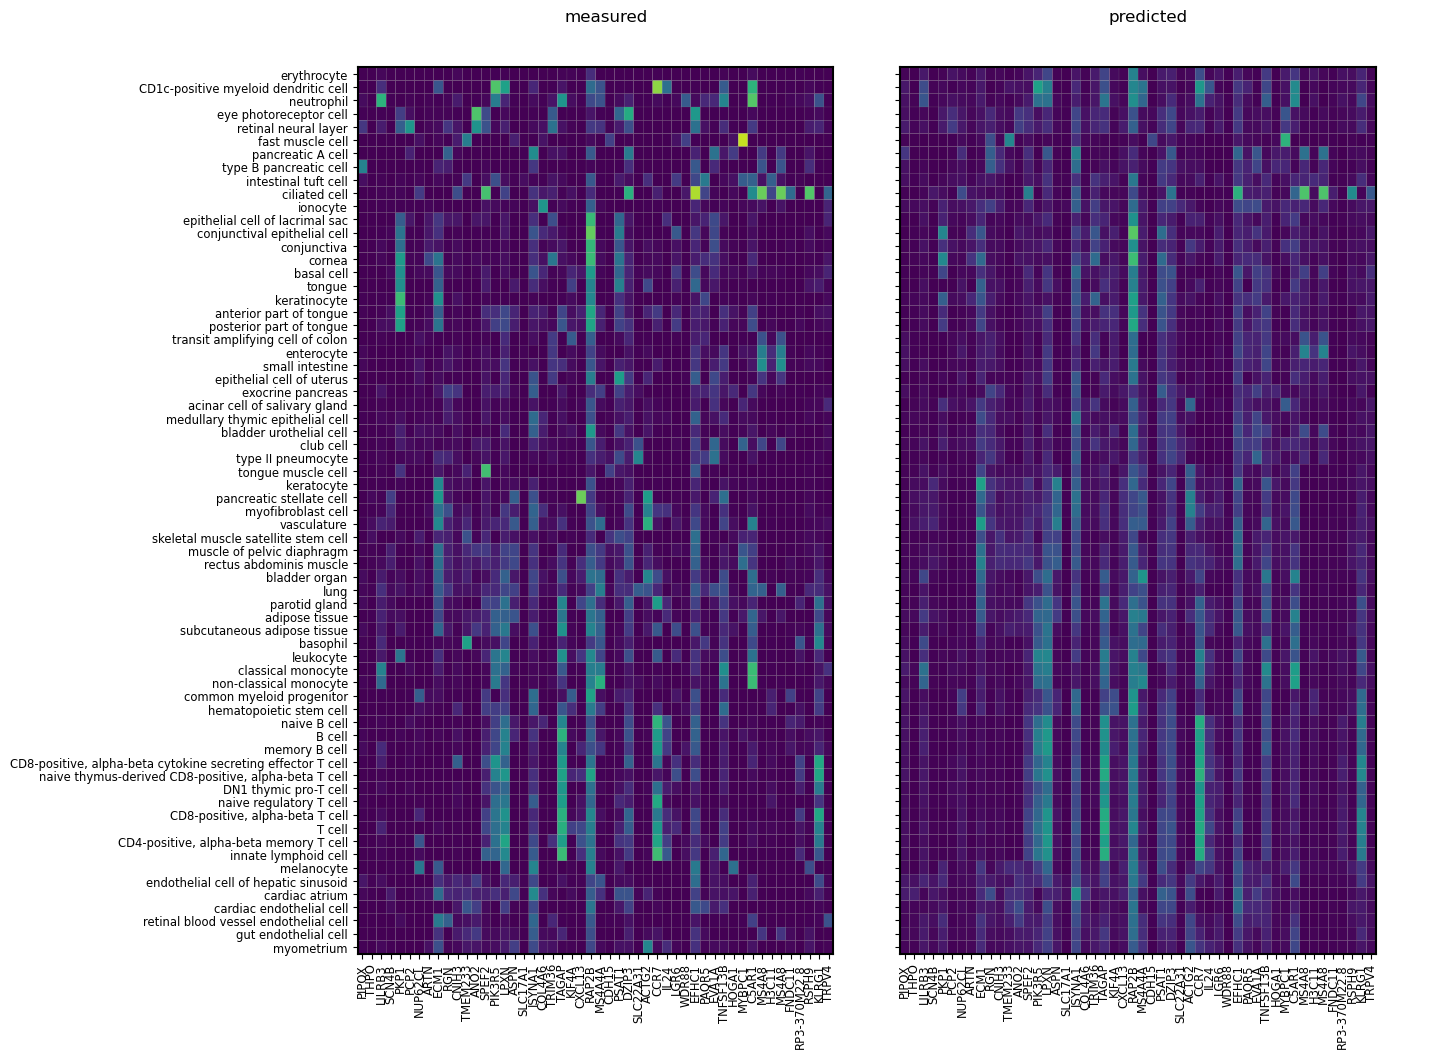

In [11]:
marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes)

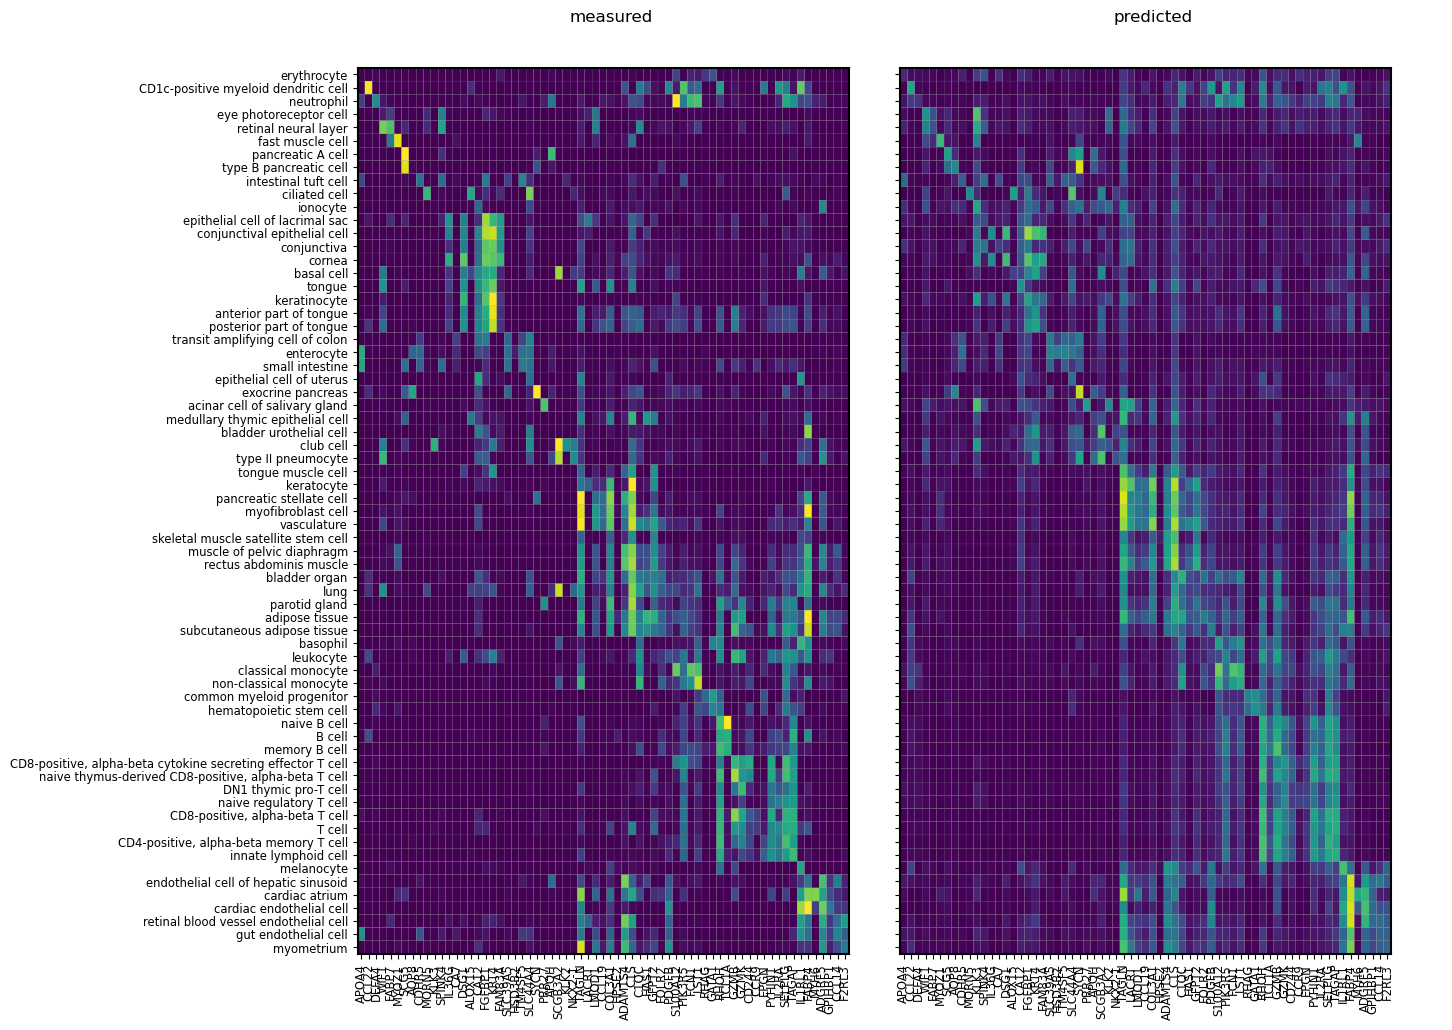

In [12]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict)

In [13]:
results['ks_statistic']

0.2027316441366791

In [14]:
results['ks_pvalue']

0.0